# Financial_Credit of Employees EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from matplotlib import font_manager, rc
font_name=font_manager.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
rc('font', family=font_name)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data load

In [ ]:
### 이미지1
df=pd.read_csv('./Data/Input/신용유의데이터_요약_(2018~2019).csv', engine='python', error_bad_lines=False)
df.head()
df.columns

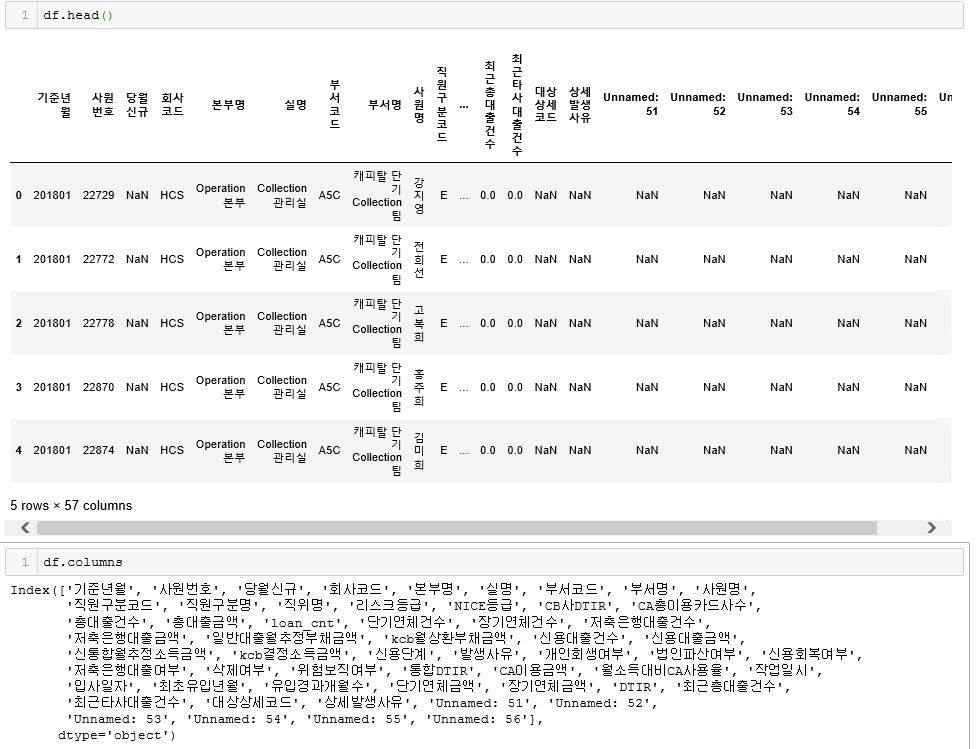

In [ ]:
df_rev=df[['기준년월','사원번호','리스크등급','NICE등급','CB사DTIR','CA총이용카드사수','총대출건수','총대출금액',
           'loan_cnt','단기연체건수','장기연체건수','저축은행대출건수','저축은행대출금액','일반대출월추정부채금액',
           'kcb월상환부채금액','신용대출건수','신용대출금액','신통합월추정소득금액','kcb결정소득금액','신용단계','통합DTIR',
           'CA이용금액','월소득대비CA사용율','단기연체금액','장기연체금액','DTIR','최근총대출건수','최근타사대출건수']]

## Data 전처리
## Data Preprocessing

In [ ]:
float_col=['리스크등급','NICE등급','CB사DTIR','CA총이용카드사수','총대출건수','총대출금액',
           'loan_cnt','단기연체건수','장기연체건수','저축은행대출건수','저축은행대출금액','일반대출월추정부채금액',
           'kcb월상환부채금액','신용대출건수','신용대출금액','신통합월추정소득금액','kcb결정소득금액','통합DTIR',
           'CA이용금액','월소득대비CA사용율','단기연체금액','장기연체금액','DTIR','최근총대출건수','최근타사대출건수']

In [ ]:
### 이미지2
df_eda=df_rev.copy()
df_eda=df_eda[float_col]
df_eda=df_eda.dropna(axis=0, how='any')
for i in float_col:
    df_eda[i]=df_eda[i].apply(lambda x:float(x))

grade=df_rev.loc[df_eda.index]['신용단계']
df_all=df.loc[df_eda.index]
df_eda=df_eda.reset_index(drop=True)
grade=grade.reset_index(drop=True)
df_all=df_all.reset_index(drop=True)

grade=grade.fillna('정상')

df_eda['grade']=grade
df_eda['grade']=df_eda['grade'].apply(lambda x: 1 if x=='정상' else x)
df_eda['grade']=df_eda['grade'].apply(lambda x: 2 if x=='신용재생' else x)
df_eda['grade']=df_eda['grade'].apply(lambda x: 3 if x=='신용악화' else x)
df_eda['grade']=df_eda['grade'].apply(lambda x: 4 if x=='신용불량' else x)

df_eda

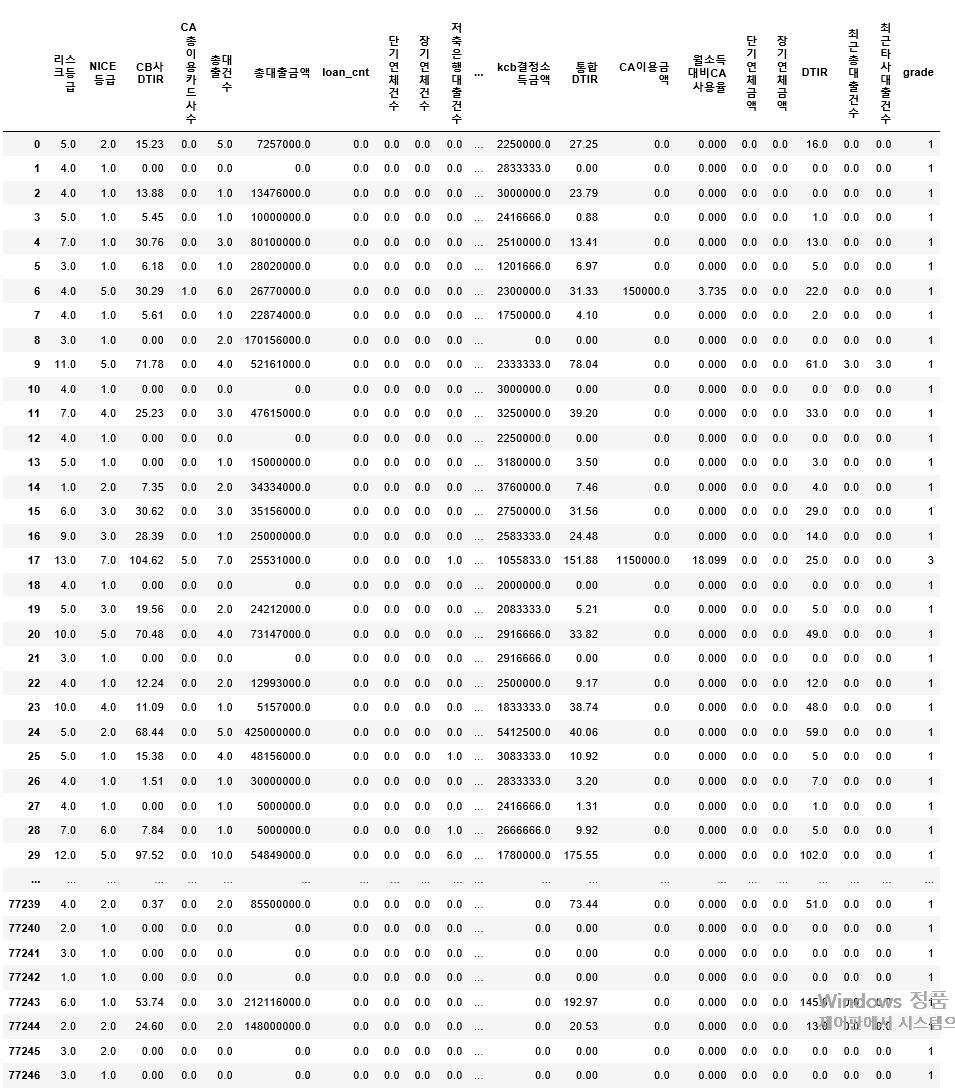

## Correlation

In [ ]:
### 이미지3, 이미지4
df_corr=df_eda.corr()
df_corr.to_csv('./Data/Output/variables_correlation.csv',encoding='cp949') # 이미지3

fig=plt.figure(figsize=(14,10))
plt.pcolor(df_corr)
plt.xticks(np.arange(df_corr.shape[0])+0.5,float_col,rotation='vertical')
plt.yticks(np.arange(df_corr.shape[1])+0.5,float_col)
plt.colorbar()
plt.show()
fig.savefig('./Data/Output/variables_correlation.png') # 이미지4

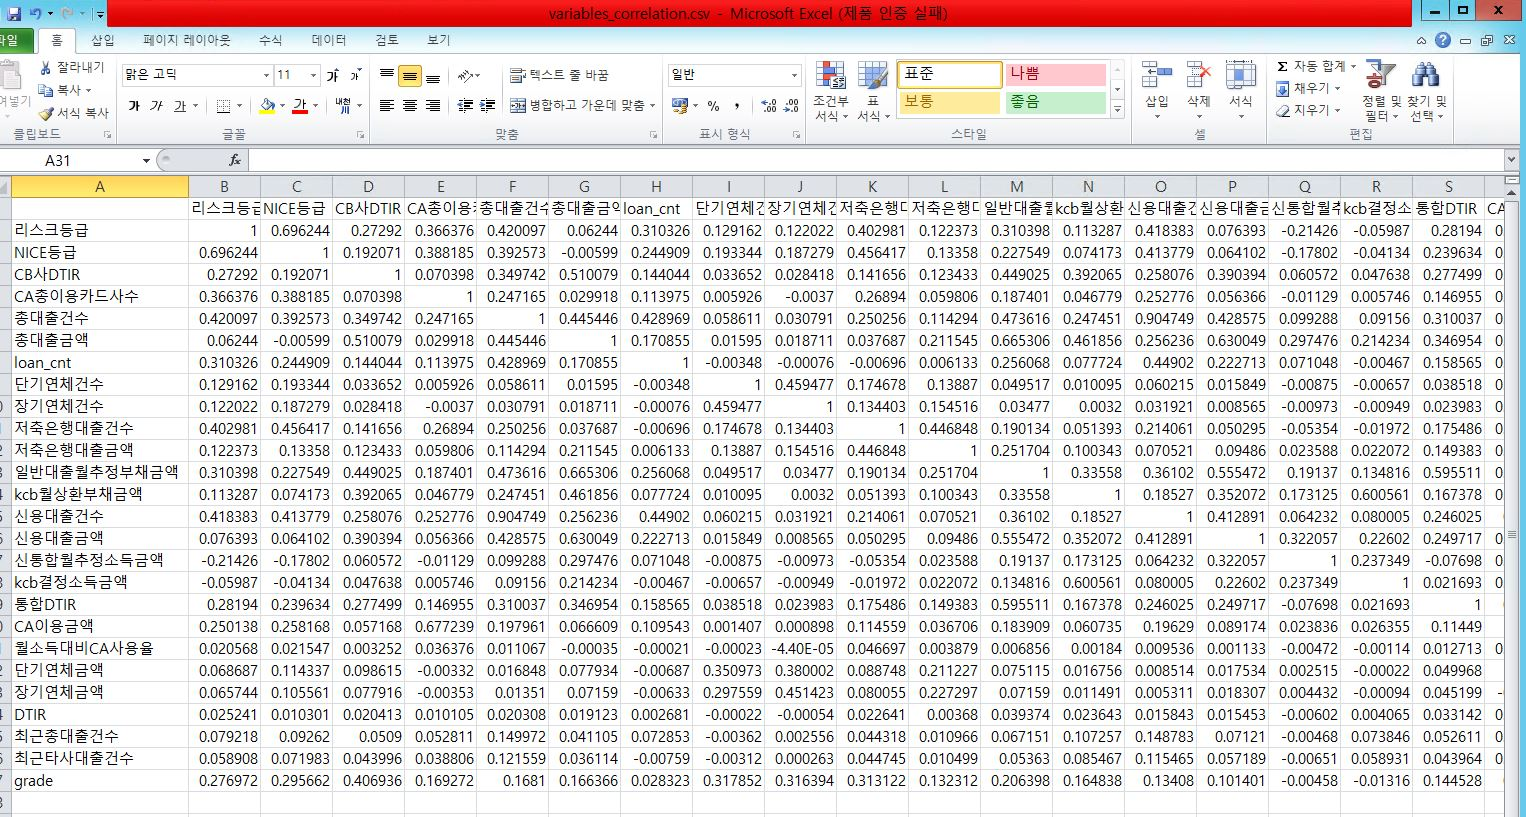

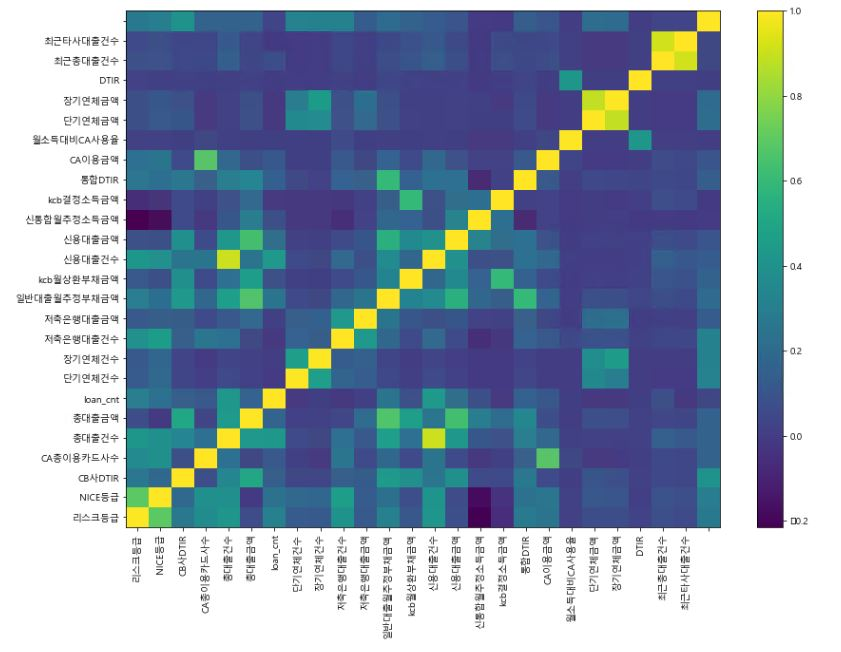

In [ ]:
### 이미지5
# correlation이 높은 변수들 확인해보기
for i in df_corr.columns:
    temp_corr=df_corr[i][np.abs(df_corr[i])>0.65]
    if len(temp_corr[temp_corr<1])!=0:
        print('------------------')
        print(i)
        print(' ')
        print(temp_corr[temp_corr<1])
        print('----------------')

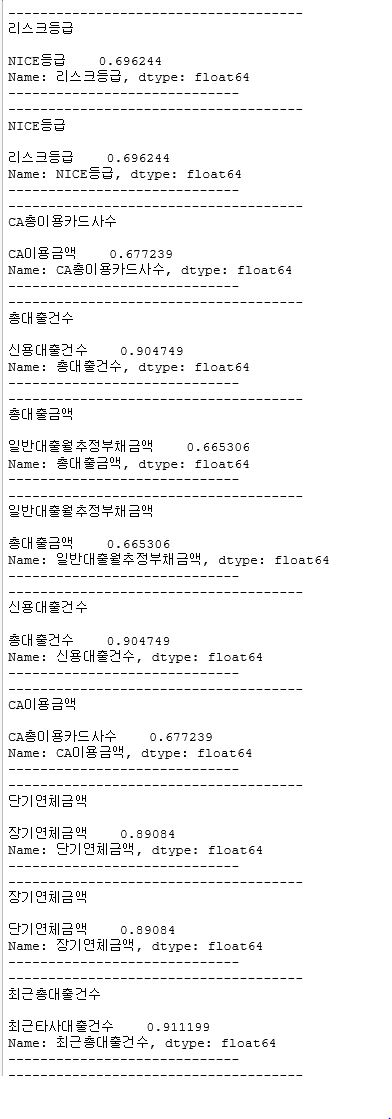

## Boxplot 및 Outlier 검출
## Boxplot graph and Outlier detect

In [ ]:
### 이미지6, 이미지7, 이미지8
selected=['리스크등급','NICE등급','CB사DTIR','총대출금액','통합DTIR','저축은행대출금액','신용대출건수','grade']
info=['기준년월','사원번호','본부명','실명','부서명','사원명','직원구분코드']
selected_df=df_all[selected]
df_all['grade']=grade

for i in range(len(selected[:-1])):
    temp_df=df_all[info+[selected[i],'grade']].copy()
    temp_df[selected[i]]=temp_df[selected[i]].apply(lambda x:float(x))
    threshold1_outlier=0.05 # 최대값 대비 몇% 까지 근처값으로 보는가
    threshold2_outlier=3    # 근처값이 몇개 이하면 outlier
    threshold3_outlier= 3   # 근처값(동일인기준) 몇개 이하면 outlier
    outlier1_df=pd.DataFrame(columns=df_all[info+[selected[i],'grade']].columns)
    while(1):
        outlier1=temp_df[temp_df[selected[i]]>=temp_df[selected[i]].max()*(1-threshold1_outlier)]
        if (len(outlier1)<=threshold2_outlier)or(len(outlier`1['사원번호'].unique())<=threshold3_outlier):
            outlier1_idx=outlier1.index
            outlier1_df=outlier1_df.append(temp_df.loc[outlier1_idx])
            temp_df.drop(outlier1_idx,inplace=True)
        else:
            break
    # outlier1: 너무 심한 수치의 outlier
    if len(outlier1_df)!=0:
        outlier1_df.to_csv('./Data/Output/'+selected[i]+'outlier1.csv',encoding='cp949') # 이미지6
        
    fig=plt.figure(figsize=(8,6))
    plt.title(selected[i])
    sns.boxplot(x='grade', y=selected[i], data=temp_df)
    plt.close()
    fig.savefig('./Data/Output/'+selected[i]+'box.png') # 이미지7
    
    
    # outlier2: 'grade'에서 신용악화, 신용재생, 신용불량의 최대값보다 '정상'의 값이 큰 애들
    idx=temp_df[temp_df['grade']=='정상'][selected[i]]>=temp_df[temp_df['grade']!='정상'][selected[i]].max()
    if len(temp_df.loc[idx[np.array(idx)==True].index])!=0:
        temp_df.loc[idx[np.array(idx)==True].index].to_csv('./Data/Output/'+selected[i]+
                                                           'outlier2.csv',encoding='cp949') #이미지8
        temp_df.drop(idx[np.array(idx)==True].index,inplace=True)

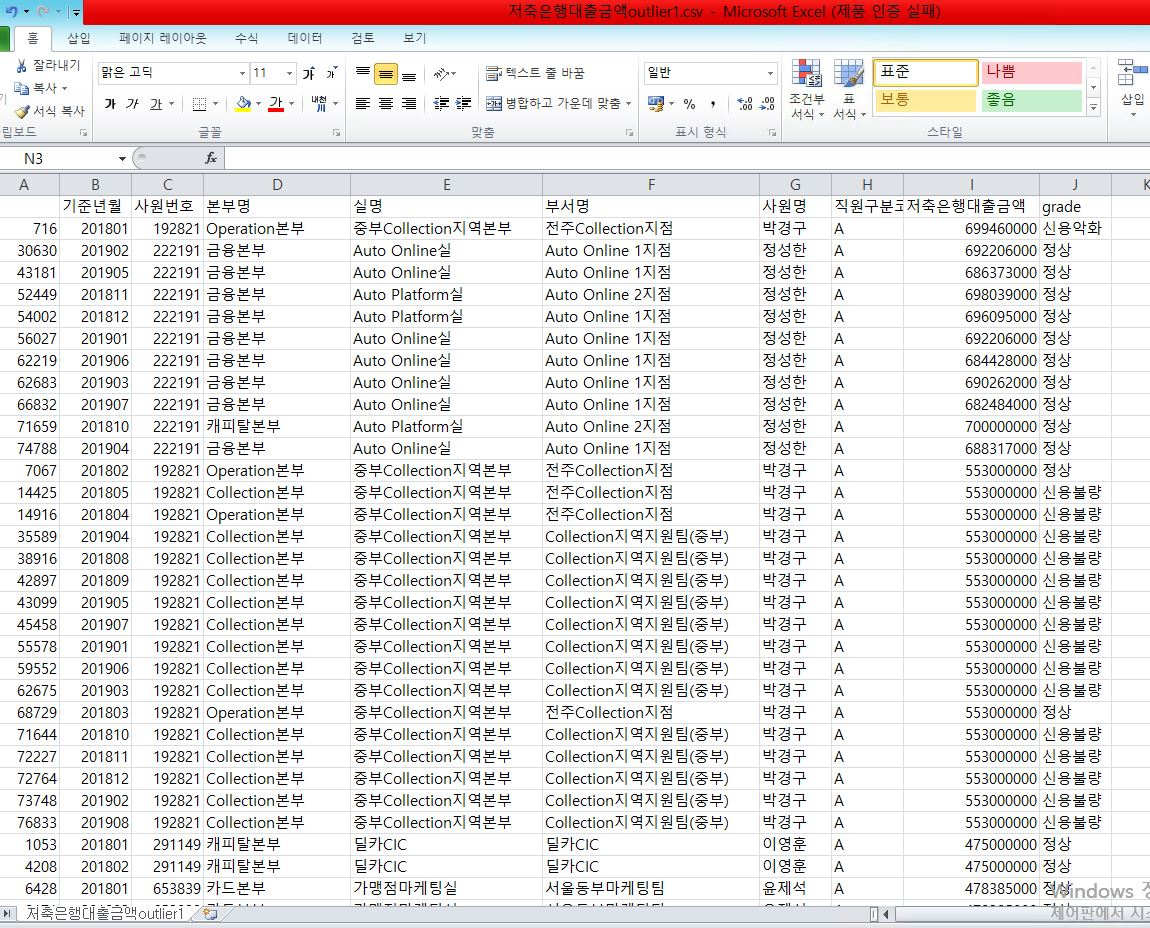

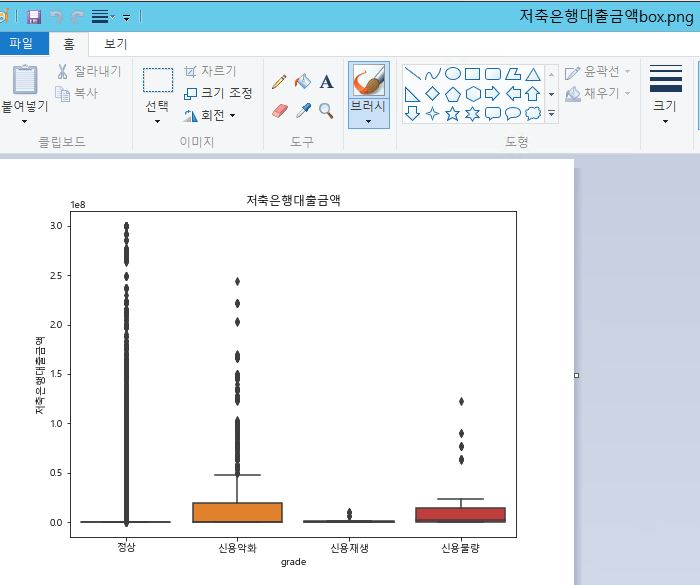

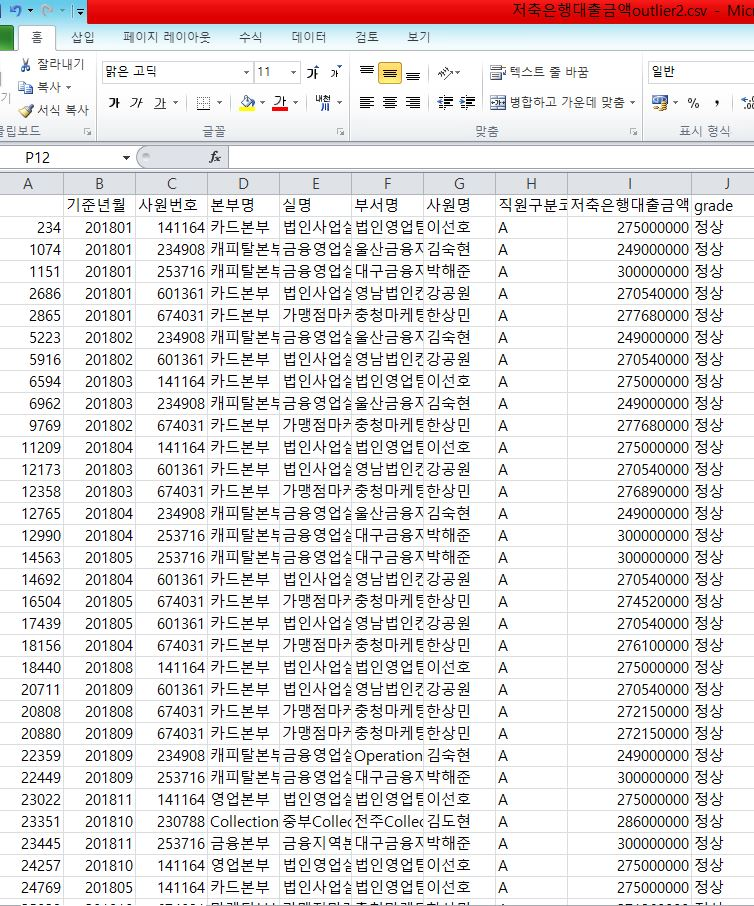

## 시계열 분석 및 outlier 검출
## Timeseries Analysis and Outlier detect

In [ ]:
### 이미지9, 이미지10, 이미지11
selected=['리스크등급','NICE등급','CB사DTIR','총대출금액','통합DTIR','저축은행대출금액','신용대출건수','grade']
info=['기준년월','사원번호','본부명','실명','부서명','사원명','직원구분코드']
ID_list=df_all['사원번호'].unique()

temp_df2=df_all[info+selected].copy()
temp_df2[selected[:-1]]=temp_df2[selected[:-1]].applymap(lambda x: float(x))

uc_list=[0 for x in range(len(selected)-1)]
lc_list=[0 for x in range(len(selected)-1)]
result_summary=pd.DataFrame(np.zeros((2,len(selected[:-1]))),columns=selected[:-1])
summary_info=list(df_all[['사원번호','사원명','직원구분코드','grade']].columns)
ym_list=list(df_all['기준년월'].unique())
result_info=['outlier_score'] # Z score
for i inrange(len(selected)-1):
    globals()['outlier_timeseries_up{}'.format(i)]=pd.DataFrame(columns=summary_info+ym_list+result_info) # 상방 리스크 outlier
    globals()['outlier_timeseries_down{}'.format(i)]=pd.DataFrame(columns=summary_info+ym_list+result_info) # 하방 리스크 outlier

sorted_personal_df=temp_df2.copy()
sorted_personal_df.sort_values(by='사원번호',inplace=True)
sorted_personal_df.reset_index(drop=True,inplace=True)

que_idx=[0]
cur_number=sorted_personal_df['사원번호'][0]
for i in range(1,len(sorted_personal_df)):
    if sorted_personal_df['사원번호'][i]!=cur_number:
        que_idx.append(i)
        cur_number=sorted_personal_df['사원번호'][i]
que_idx.append(i+1)

for q,que in enumerate(que_idx[:-1]):
    personal_df=sorted_personal_df.iloc[que_idx[q]:que_idx[q+1]]
    personal_df.sort_values(by='기준년월',inplace=True)
    personal_df.reset_index(drop=True, inplace=True)
    
    threshold_obs=12
    if len(personal_df)<threshold_obs:
        continue
    
    threshold_std=3.5
    for i in range(len(selected)-1):
        diff_list=(personal_df[selected[i]]-personal_df[selected[i]].shift(1)).dropna()
        diff_mean=diff_list.mean()
        diff_std=diff_list.std()
        upper_bound=diff_mean+threshold_std*diff_std
        lower_bound=diff_mean-threshold_std*diff_std
        if personal_df[selected[i]].max()-personal_df[selected[i]].min()<2: # 등급 및 건수는 2개 이상인것만 검출
            continue
        if len(diff_list[upper_bound<diff_list])!=0: # 상방 risk
            temp_df_outlier=pd.DataFrame(-1*np.ones((1,len(summary_info+ym_list+result_info))),
                                         columns=summary_info+ym_list+result_info)
            temp_df_outlier[summary_info]=list(personal_df[summary_info].iloc[0,:])
            for p_idx in range(len(personal_df)):
                ym=personal_df.index[p_idx]
                temp_df_outlier[ym]=personal_df.loc[ym,selected[i]]
            temp_df_outlier['outlier_score']=np.max((diff_list-diff_mean)/diff_std)
            globals()['outlier_timeseries_up{}'.format(i)]=globals()['outlier_timeseries_up{}'.format(i)].append(temp_df_outlier)
            uc_list[i]+=1
        
        if len(diff_list[lower_bound>diff_list])!=0: # 하방 risk
            temp_df_outlier=pd.DataFrame(-1*np.ones((1,len(summary_info+ym_list+result_info))),
                                         columns=summary_info+ym_list+result_info)
            temp_df_outlier[summary_info]=list(personal_df[summary_info].iloc[0,:])
            for p_idx in range(len(personal_df)):
                ym=personal_df.index[p_idx]
                temp_df_outlier[ym]=personal_df.loc[ym,selected[i]]
            temp_df_outlier['outlier_score']=np.max(abs((diff_list-diff_mean)/diff_std))
            globals()['outlier_timeseries_down{}'.format(i)]=globals()['outlier_timeseries_down{}'.format(i)].append(temp_df_outlier)
            lc_list[i]+=1
            
            
for i in range(len(selected)-1):
    globals()['outlier_timeseries_up{}'.format(i)]=globals()['outlier_timeseries_up{}'.format(i)].applymap(lambda x:''
                                                                                                          if x==-1 else x)
    globals()['outlier_timeseries_up{}'.format(i)].to_csv('./Data/Output/'+
                                                          selected[i]+'outlier_ts_up.csv',encoding='cp949') # 이미지9
    globals()['outlier_timeseries_down{}'.format(i)]=globals()['outlier_timeseries_down{}'.format(i)].applymap(lambda x:''
                                                                                                          if x==-1 else x)
    globals()['outlier_timeseries_down{}'.format(i)].to_csv('./Data/Output/'+
                                                            selected[i]+'outlier_ts_down.csv',encoding='cp949') # 이미지10
            
            
result_summary.iloc[0,:]=np.array(uc_list)
result_summary.iloc[1,:]=np.array(lc_list)
result_summary['Total']=np.sum(result_summary,axis=1)
result_summary.index=np.array(['Upside_risk', 'Downside_risk'])
result_summary.to_csv('./Data/Output/result_summary.csv',encoding='cp949') # 이미지11
            

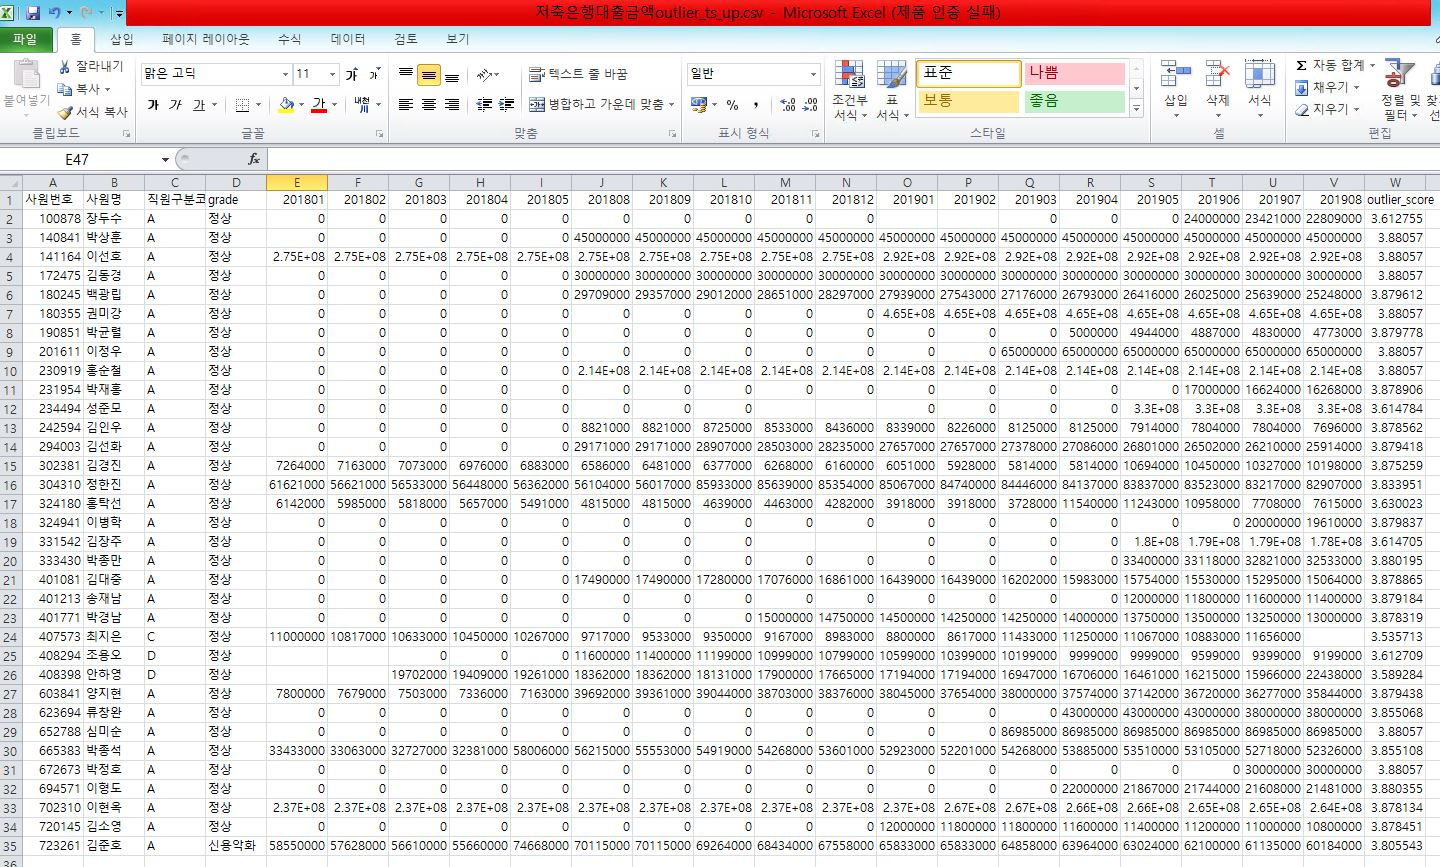

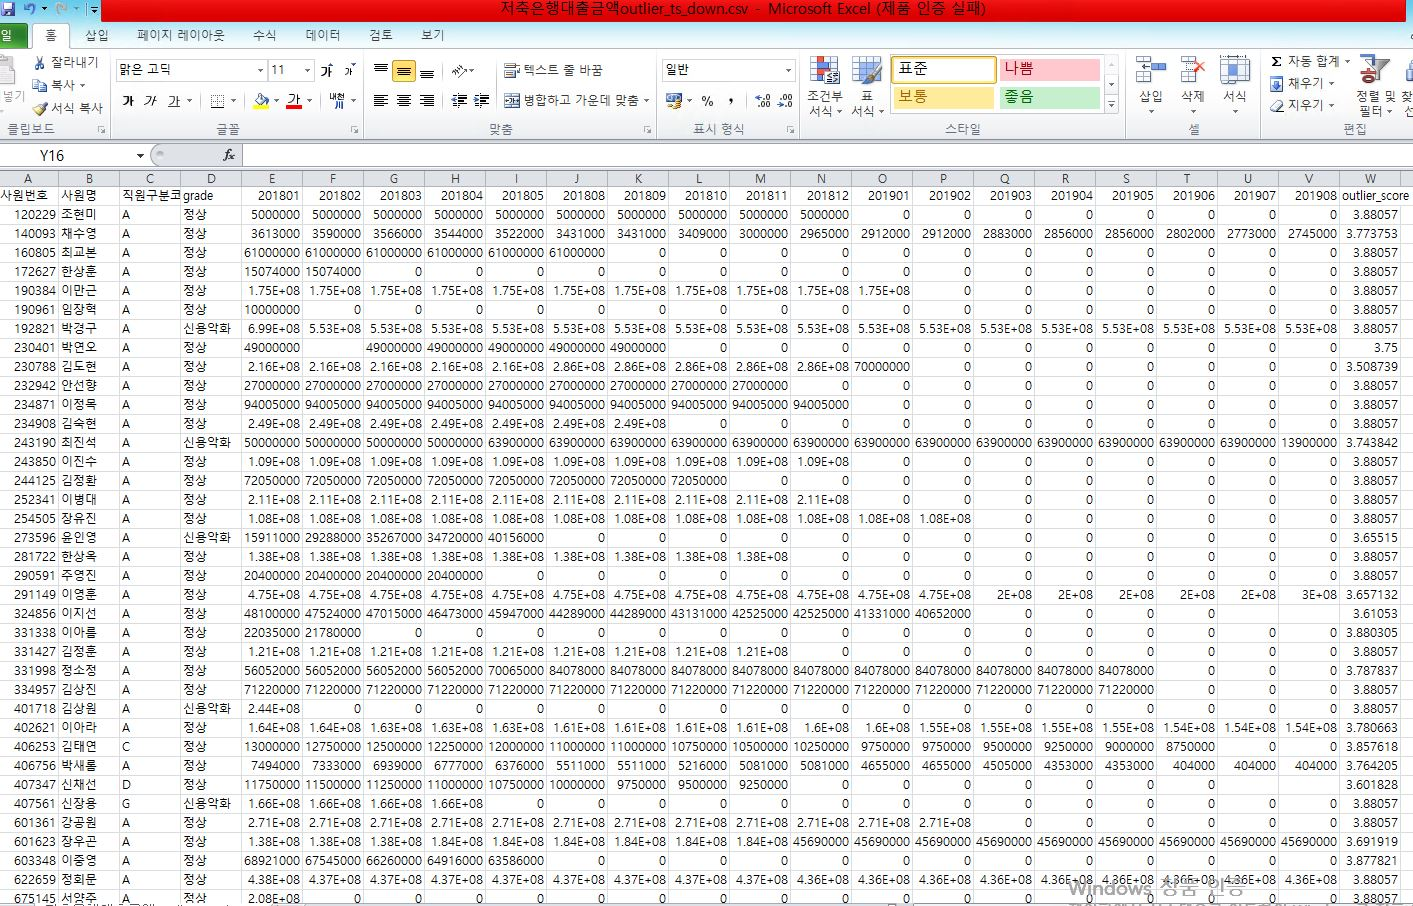

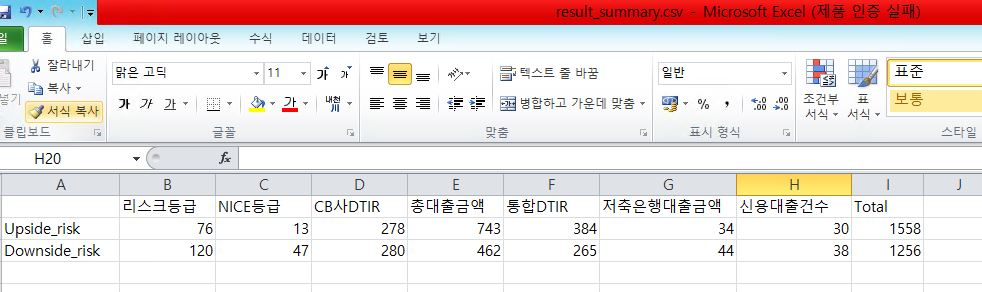